In [1]:
import aesara.tensor as aet
import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
import xarray
from scipy.special import expit as logistic

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


In [2]:
arviz.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

## Data

In [3]:
results_by_regions = pd.read_csv(
    "https://raw.githubusercontent.com/pollsposition/data/main/results_by_regions.csv"
)
results_by_regions["region"] = results_by_regions.region.str.replace(
    "La Réunion", "Réunion"
)
subset = (
    results_by_regions[
        (results_by_regions.type.isin(["president", "european"]))
        & (~results_by_regions.region.isin(["Mayotte"]))
        & (results_by_regions.election_day >= "2014") # because no DOM unemployment before
    ]
    .reset_index(drop=True)
    .set_index(["election_day", "region"])
    .sort_index()
)
subset

type        N  farleft    left  \
election_day region                                                            
2014-05-25   Auvergne-Rhône-Alpes         european  2211437   135917  302017   
             Bourgogne-Franche-Comté      european   868611    54422  123195   
             Bretagne                     european  1055623    53023  169560   
             Centre-Val de Loire          european   776648    49306   99548   
             Corse                        european    79982     4792    7528   
             Grand Est                    european  1559789    72847  198368   
             Guadeloupe                   european    26344        0    6244   
             Guyane                       european     7887        0     588   
             Hauts-de-France              european  1706183   114135  191090   
             Ile-de-France                european  2950984   193249  422542   
             Martinique                   european    31206        0    6446   
             Normandie                    european  1012958    59396  129160   
             Nouvelle-Aquitaine           european  1869743   143144  323670   
             Occitanie                    european  1879000   167401  291132   
             Pays de la Loire             european  1122577    53786  167904   
             Provence-Alpes-Côte d'Azur   european  1461937    94010  154293   
             Réunion                      european   115122        0   17840   
2017-04-23   Auvergne-Rhône-Alpes        president  4187716   805588  256532   
             Bourgogne-Franche-Comté     president  1544906   276958   87386   
             Bretagne                    president  2000330   385736  180827   
             Centre-Val de Loire         president  1427614   252308   83552   
             Corse                       president   154376    21314    5780   
             Grand Est                   president  2971625   484810  151296   
             Guadeloupe                  president   112242    27081   11165   
             Guyane                      president    26839     6633    1529   
             Hauts-de-France             president  3232524   633313  166630   
             Ile-de-France               president  5631456  1224978  430324   
             Martinique                  president   109264    29903   10661   
             Normandie                   president  1891428   362426  113705   
             Nouvelle-Aquitaine          president  3389374   703439  240157   
             Occitanie                   president  3315700   734193  216349   
             Pays de la Loire            president  2191921   403455  143491   
             Provence-Alpes-Côte d'Azur  president  2750937   515415  113365   
             Réunion                     president   350480    85987   26872   
2019-05-26   Auvergne-Rhône-Alpes         european  2663031   153648  159678   
             Bourgogne-Franche-Comté      european   992488    62237   55428   
             Bretagne                     european  1286881    71550   97318   
             Centre-Val de Loire          european   902492    50911   52056   
             Corse                        european    85900     2707    3004   
             Grand Est                    european  1857234    95065   91853   
             Guadeloupe                   european    38256     4957    3445   
             Guyane                       european    11522     1562     665   
             Hauts-de-France              european  2060762   145260   96001   
             Ile-de-France                european  3536313   218578  231640   
             Martinique                   european    39362     5099    3350   
             Normandie                    european  1211420    75665   71759   
             Nouvelle-Aquitaine           european  2222990   156342  172774   
             Occitanie                    european  2186389   162093  165841   
             Pays de la Loire             euro

In [4]:
COORDS = {
    "parties": ["farleft", "left", "green", "center", "right", "farright"],
    "parties_complete": [
        "farleft",
        "left",
        "green",
        "center",
        "right",
        "farright",
        "other",
    ],
    "observations": subset.index,
}

In [5]:
# small data sanity check
raw_N = subset[COORDS["parties_complete"]].sum(1)
subset["N"].equals(raw_N)

True

In [6]:
# second sanity check
subset[subset.isna().any(axis=1)]

Empty DataFrame
Columns: [type, N, farleft, left, green, center, right, farright, other]
Index: []

In [7]:
# prevents overflow issue
# TODO: stats consequences?
subset[COORDS["parties_complete"]] = subset[COORDS["parties_complete"]] // 100

## Simplest fundamentals model

In [42]:
with pm.Model(coords=COORDS) as m_real:
    n_cutpoints = len(COORDS["parties"])
    cut_base = pm.Normal("cut_base", mu=-1, sigma=3)
    cut_diffs = pm.HalfNormal("cut_diffs", sigma=2 / n_cutpoints, shape=n_cutpoints - 1)

    cutpoints = pm.Deterministic(
        "cutpoints",
        aet.concatenate([[cut_base], cut_base + cut_diffs.cumsum()]),
        dims="parties",
    )

    # cutpoints = pm.Normal(
    #   "cutpoints",
    #  mu=np.arange(6) - 2.5,
    # sigma=1.5,
    # initval=np.arange(6) - 2.5,
    # transform=pm.distributions.transforms.ordered,
    # dims="parties",
    # )

    pm.OrderedMultinomial(
        "results",
        eta=0,
        cutpoints=cutpoints,
        n=subset[COORDS["parties_complete"]].sum(1).values,
        observed=subset[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    trace = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={"results_probs": ["parties_complete"]},
            coords={
                "parties_complete": COORDS["parties_complete"],
            },
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cut_base, cut_diffs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


0, dim: observations, 140 =? 140


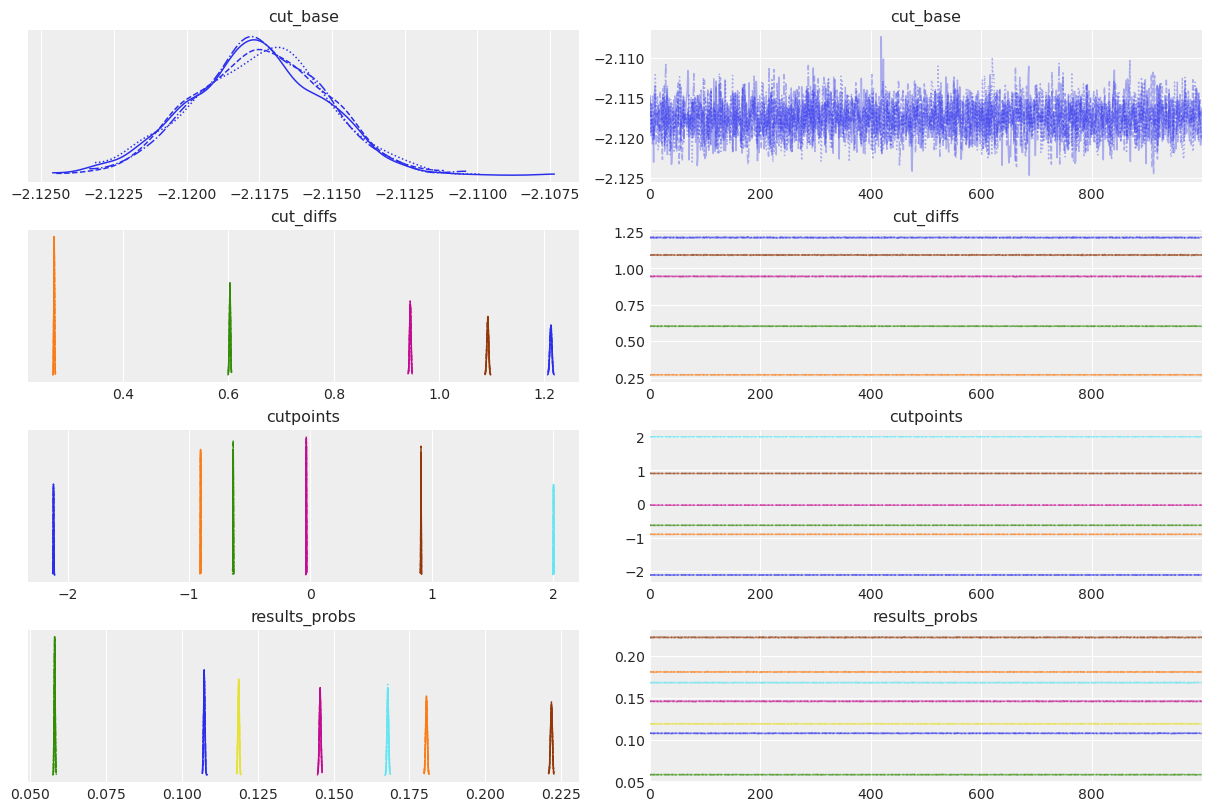

In [44]:
arviz.plot_trace(trace);

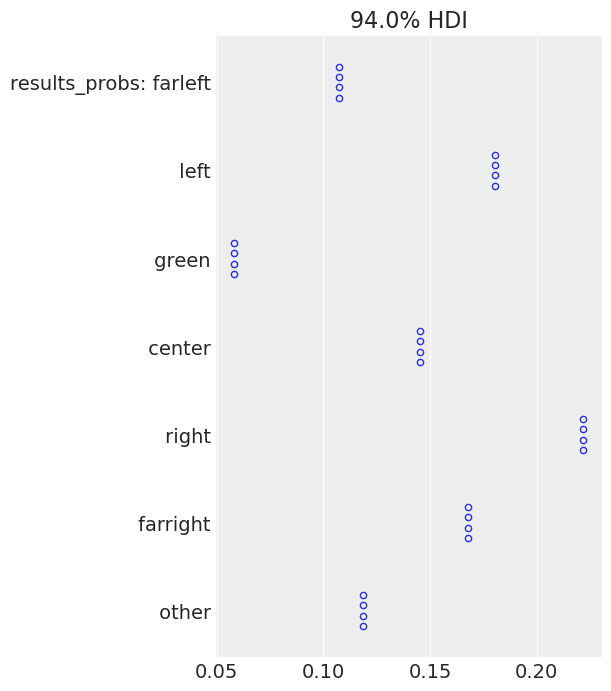

In [46]:
arviz.plot_forest(trace, var_names="results_probs");

## Regional fundamentals model

In [8]:
region_idx, COORDS["regions"] = pd.factorize(
    subset.index.get_level_values("region"), sort=True
)

In [80]:
with pm.Model(coords=COORDS) as m_real:

    initval = np.tile(
        np.arange(len(COORDS["parties"])) - 2.5, reps=(len(COORDS["regions"]), 1)
    )
    cutpoints = pm.Normal(
        "cutpoints",
        mu=initval,
        sigma=3.0,
        initval=initval,
        transform=pm.distributions.transforms.ordered,
        dims=("regions", "parties"),
    )

    pm.OrderedMultinomial(
        "results",
        eta=0,
        cutpoints=cutpoints[region_idx],
        n=subset[COORDS["parties_complete"]].sum(1).values,
        observed=subset[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    trace = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={"results_probs": ["observations", "parties_complete"]},
            # coords={
            #   "parties_complete": COORDS["parties_complete"],
            # }
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[18  6]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


0, dim: observations, 140 =? 140


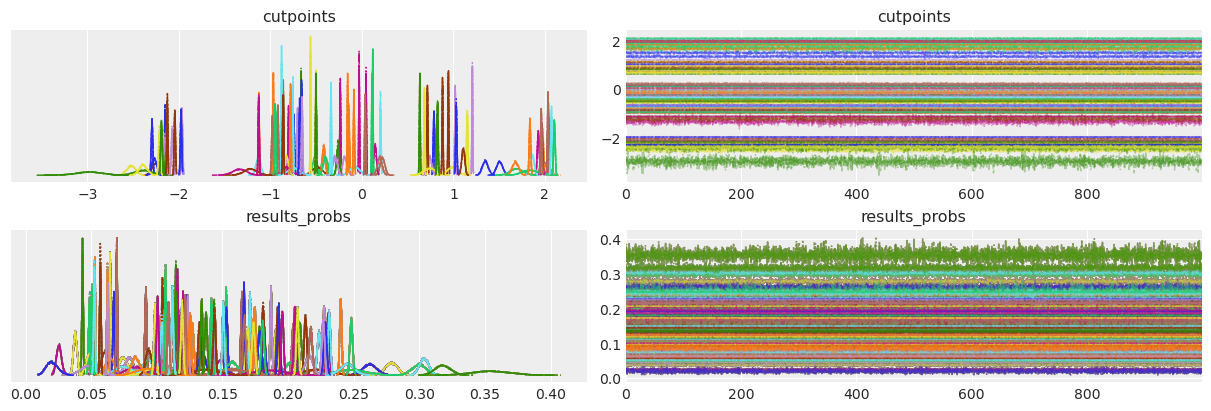

In [82]:
arviz.plot_trace(trace);

## Hierarchical simple fundamentals model

In [10]:
with pm.Model(coords=COORDS) as m_real:

    init_mean = np.arange(len(COORDS["parties"])) - 2.5
    mean = pm.Normal(
        "cutpoint_mean",
        mu=init_mean,
        sigma=3.0,
        initval=init_mean,
        transform=pm.distributions.transforms.ordered,
        dims="parties",
    )
    sd = pm.HalfNormal("cutpoint_sd")

    init_cut = np.tile(
        np.arange(len(COORDS["parties"])) - 2.5, reps=(len(COORDS["regions"]), 1)
    )
    cutpoints = pm.Normal(
        "cutpoints",
        mu=mean,
        sigma=sd,
        initval=init_cut,
        transform=pm.distributions.transforms.ordered,
        dims=("regions", "parties"),
    )

    pm.OrderedMultinomial(
        "results",
        eta=0,
        cutpoints=cutpoints[region_idx],
        n=subset[COORDS["parties_complete"]].sum(1).values,
        observed=subset[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    trace = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={"results_probs": ["observations", "parties_complete"]},
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoint_mean, cutpoint_sd, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


0, dim: observations, 51 =? 51


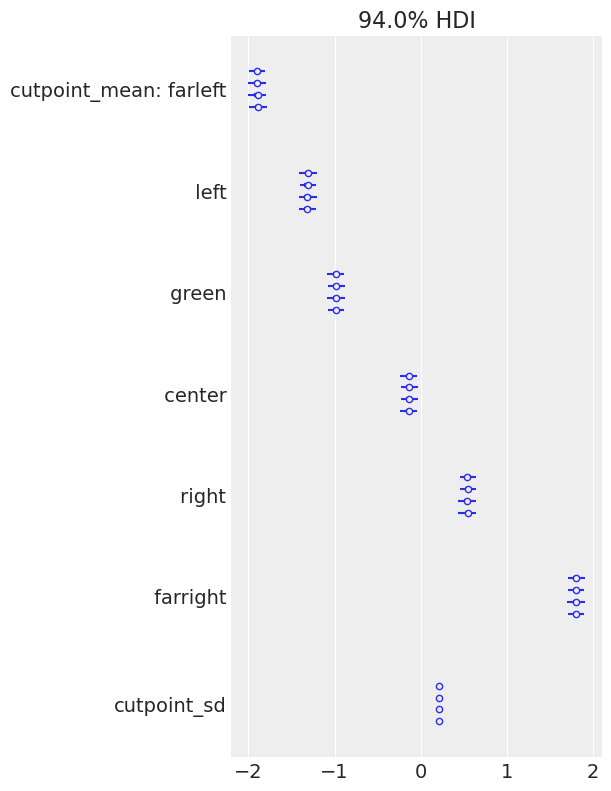

In [11]:
arviz.plot_forest(trace, var_names="cutpoint_", filter_vars="like");

In [15]:
def compute_p_from_cutpoints(posterior):
    # need to include eta in computation

    #   pa = sigmoid(cutpoints - at.shape_padright(eta))
    #    p_cum = at.concatenate(
    # [
    #      at.zeros_like(at.shape_padright(pa[..., 0])),
    #       pa,
    #        at.ones_like(at.shape_padright(pa[..., 0])),
    #     ],
    #      axis=-1,
    #   )
    #    p = p_cum[..., 1:] - p_cum[..., :-1]

    p_cum = logistic(posterior.cutpoints)

    zeros = xarray.zeros_like(p_cum.sel(parties="farleft"))
    zeros.coords["parties"] = "dummy"

    ones = xarray.ones_like(p_cum.sel(parties="farleft"))
    ones.coords["parties"] = "other"

    return xarray.concat([zeros, p_cum, ones], dim="parties").diff(dim="parties")

In [12]:
p_cum = compute_p_from_cutpoints(trace.posterior)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

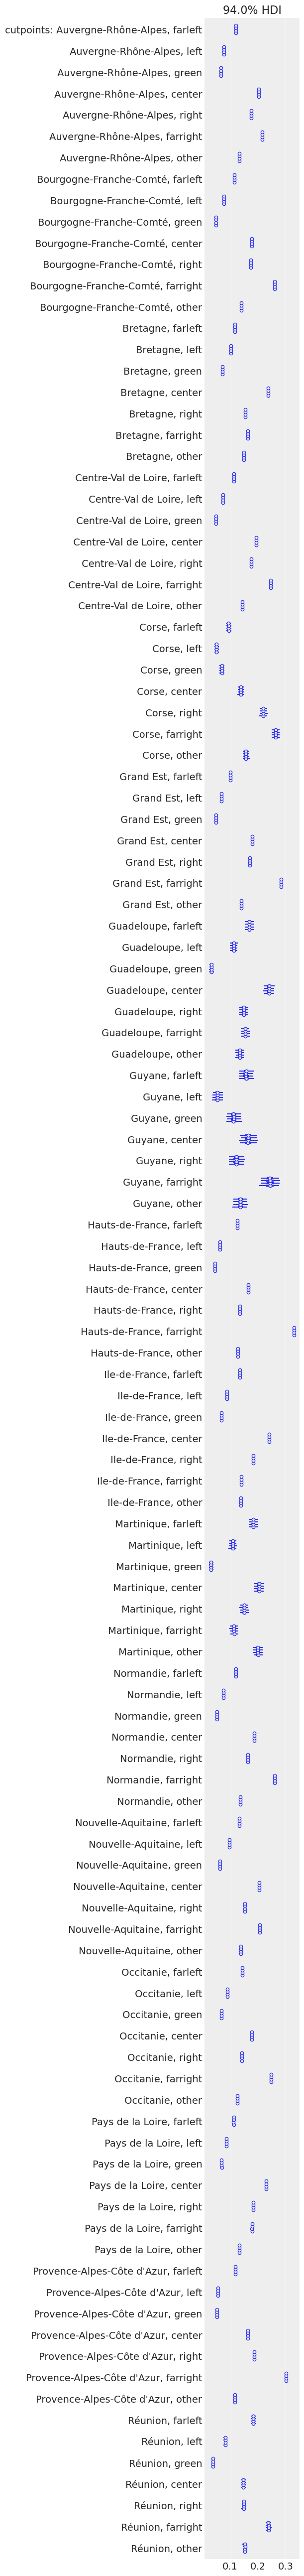

In [14]:
arviz.plot_forest(p_cum);

## Hierarchical fundamentals model with 1 predictor

In [9]:
unemp = pd.read_excel(
    "../../data/predictors/chomage_reg_depart_trim.xls",
    sheet_name="Région",
    header=3,
    nrows=19,
).iloc[2:]

# remove accents and special characters, then remove hyphens
unemp["normalized_region"] = unemp["Libellé"].str.lower().str.replace("-", " ").values

unemp = unemp.drop(["Code", "Libellé"], axis=1).set_index("normalized_region")

In [10]:
# as timestamps variables:
unemp.columns = pd.period_range(
    start=unemp.columns[0].split("_")[1], periods=unemp.shape[1], freq="Q"
)
unemp.columns.name = "quarter"
unemp = pd.DataFrame(unemp.stack().swaplevel(), columns=["unemployment"])

In [11]:
# normalize regions of data before joining
subset["normalized_region"] = (
    subset.reset_index()
    .region.str.lower()
    .str.normalize("NFKD")
    .str.encode("ascii", errors="ignore")
    .str.decode("utf-8")
    .str.replace("-", " ")
    .values
)

subset = subset.reset_index()

# add quarters to results dataframe:
subset["quarter"] = pd.DatetimeIndex(subset["election_day"].values).to_period("Q")
subset = subset.set_index(["quarter", "normalized_region"])

In [12]:
subset = (
    subset.merge(unemp, left_index=True, right_index=True)
    .reset_index(drop=True)
    .set_index(["election_day", "region"])
)

In [19]:
with pm.Model(coords=COORDS) as m_real:

    # hierarchical layer cutpoints
    init_mean = np.arange(len(COORDS["parties"])) - 2.5
    mean = pm.Normal(
        "cutpoint_mean",
        mu=init_mean,
        sigma=3.0,
        initval=init_mean,
        transform=pm.distributions.transforms.ordered,
        dims="parties",
    )
    sd = pm.HalfNormal("cutpoint_sd")

    # cutpoints
    init_cut = np.tile(
        np.arange(len(COORDS["parties"])) - 2.5, reps=(len(COORDS["regions"]), 1)
    )
    cutpoints = pm.Normal(
        "cutpoints",
        mu=mean,
        sigma=sd,
        initval=init_cut,
        transform=pm.distributions.transforms.ordered,
        dims=("regions", "parties"),
    )

    # regression
    regression_mean = pm.Normal("regression_mean")
    shrinkage = pm.HalfNormal("regression_shrinkage")
    bU = pm.Normal("unemp_effect", regression_mean, shrinkage, dims="regions")
    U = pm.Data("unemp_data", subset.unemployment.values)
    eta = pm.Deterministic("eta", bU[region_idx] * U, dims="observations")

    pm.OrderedMultinomial(
        "results",
        eta=eta,
        cutpoints=cutpoints[region_idx],
        n=subset[COORDS["parties_complete"]].sum(1).values,
        observed=subset[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    trace = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={
                "results_probs": ["observations", "parties_complete"]
            },  # "eta": ["observations"]
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoint_mean, cutpoint_sd, cutpoints, regression_mean, regression_shrinkage, unemp_effect]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.


0, dim: observations, 51 =? 51


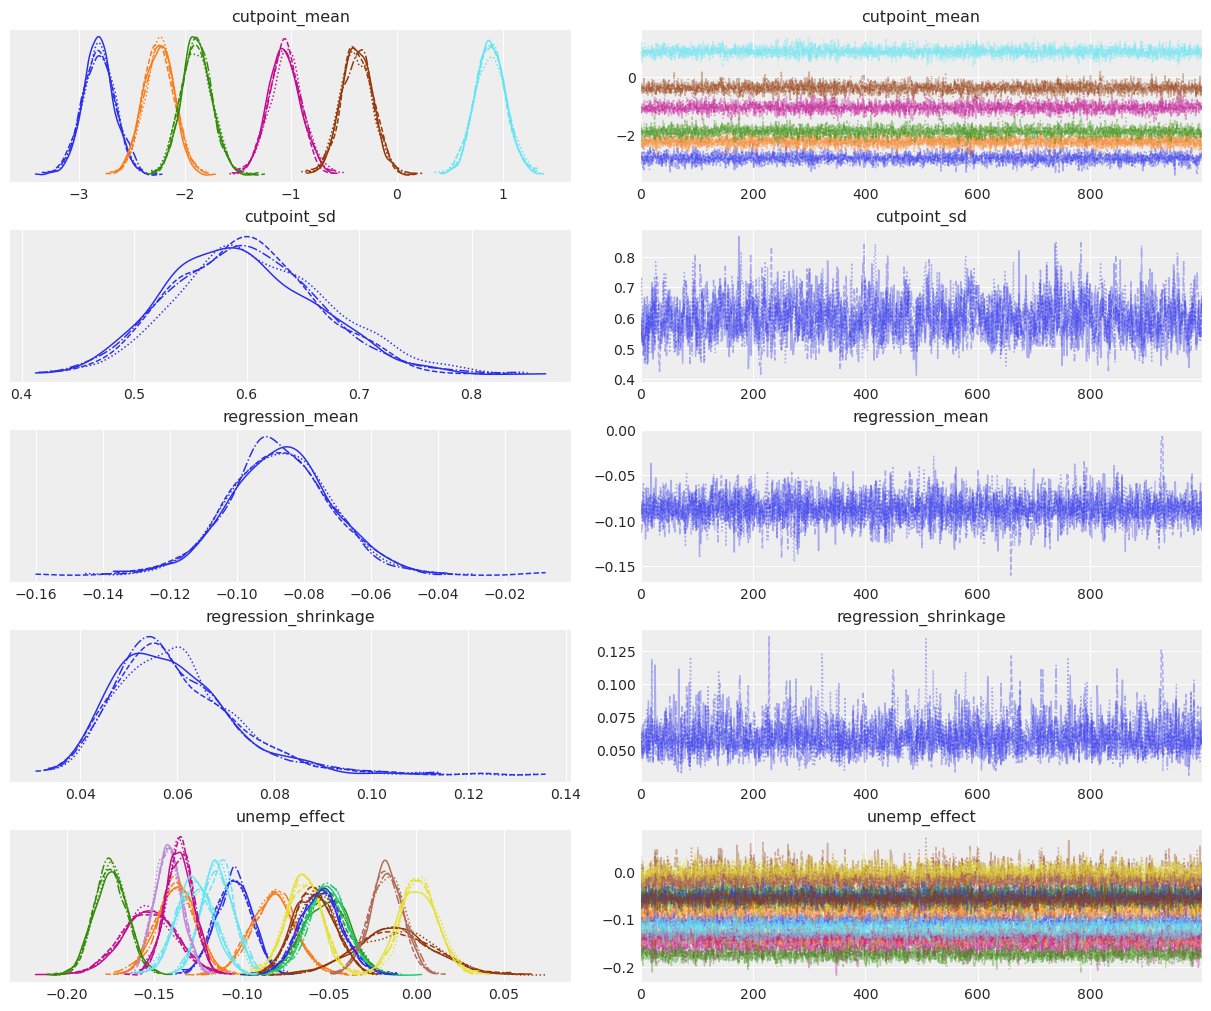

In [20]:
arviz.plot_trace(
    trace, var_names=["cutpoint_", "regression_", "unemp_effect"], filter_vars="like"
);

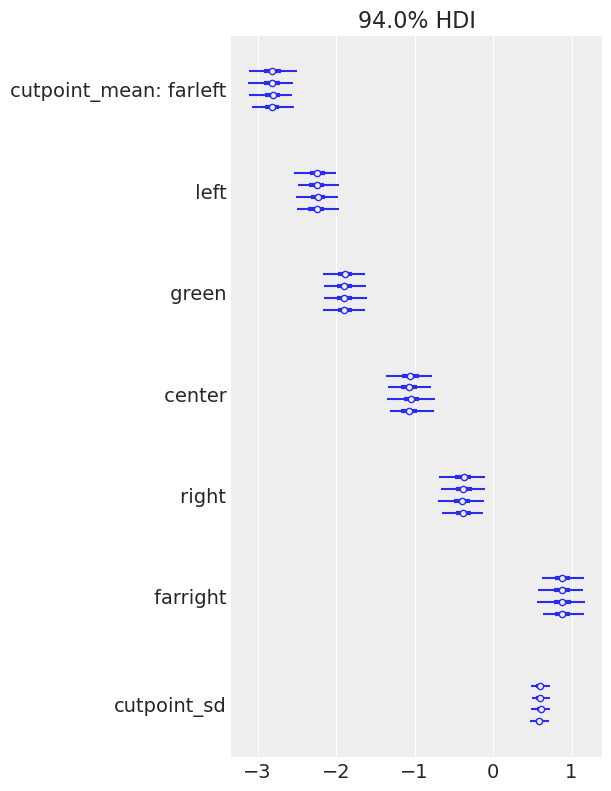

In [21]:
arviz.plot_forest(trace, var_names=["cutpoint_"], filter_vars="like");

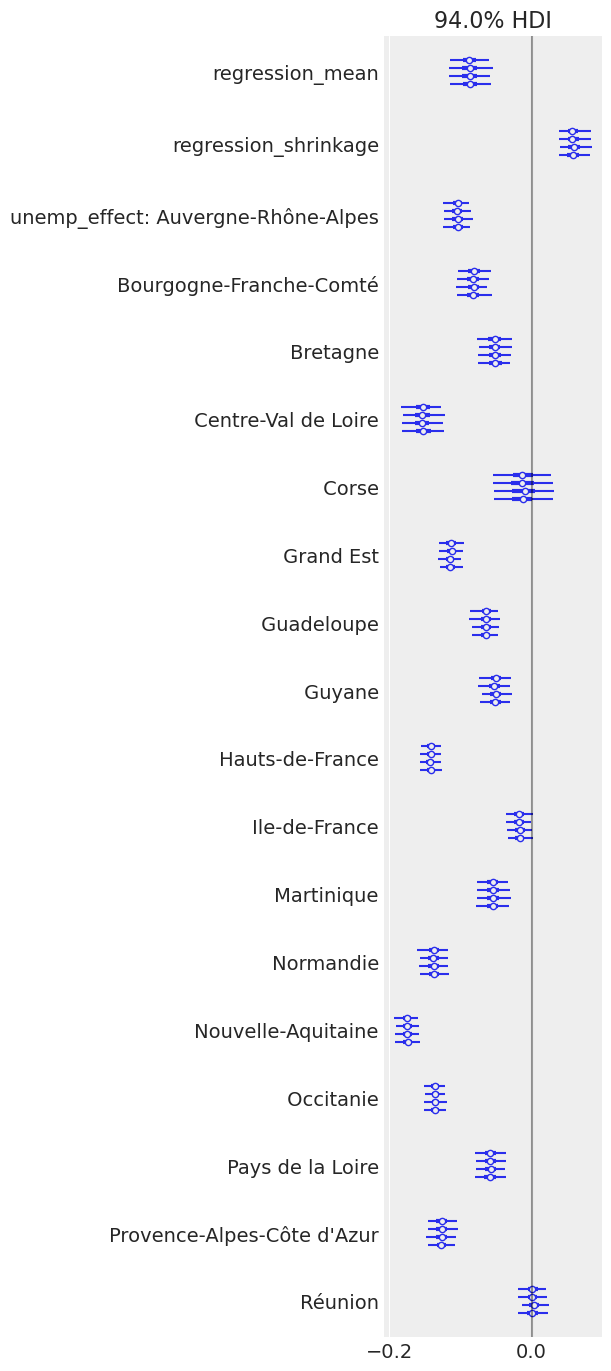

In [22]:
ax = arviz.plot_forest(
    trace, var_names=["regression_", "unemp_effect"], filter_vars="like"
)
ax[0].axvline(c="k", alpha=0.4);

In [27]:
ref_vals = subset[COORDS["parties_complete"]].div(
    subset[COORDS["parties_complete"]].sum(1).values, axis="rows"
)

In [45]:
ref_vals.loc[(slice(None), "Auvergne-Rhône-Alpes"), :]

farleft      left     green    center  \
election_day region                                                         
2014-05-25   Auvergne-Rhône-Alpes  0.061463  0.136584  0.101036  0.099272   
2017-04-23   Auvergne-Rhône-Alpes  0.192363  0.061255  0.000000  0.244973   
2019-05-26   Auvergne-Rhône-Alpes  0.057686  0.059939  0.149698  0.226537   

                                      right  farright     other  
election_day region                                              
2014-05-25   Auvergne-Rhône-Alpes  0.217855  0.238162  0.145629  
2017-04-23   Auvergne-Rhône-Alpes  0.202011  0.207169  0.092229  
2019-05-26   Auvergne-Rhône-Alpes  0.103804  0.209937  0.192399

In [50]:
trace.posterior.results_probs.sel(
    observations=[
        ("2014-05-25", "Auvergne-Rhône-Alpes"),
        ("2017-04-23", "Auvergne-Rhône-Alpes"),
        ("2019-05-26", "Auvergne-Rhône-Alpes"),
    ]
).mean(("chain", "draw")).to_dataframe().unstack()

results_probs                                \
parties_complete                        farleft      left     green    center   
election_day region                                                             
2014-05-25   Auvergne-Rhône-Alpes      0.128077  0.083060  0.071206  0.206954   
2017-04-23   Auvergne-Rhône-Alpes      0.122359  0.080214  0.069313  0.204379   
2019-05-26   Auvergne-Rhône-Alpes      0.112624  0.075197  0.065871  0.199207   

                                                                 
parties_complete                      right  farright     other  
election_day region                                              
2014-05-25   Auvergne-Rhône-Alpes  0.175167  0.208432  0.127104  
2017-04-23   Auvergne-Rhône-Alpes  0.176466  0.214263  0.133007  
2019-05-26   Auvergne-Rhône-Alpes  0.178239  0.224640  0.144222

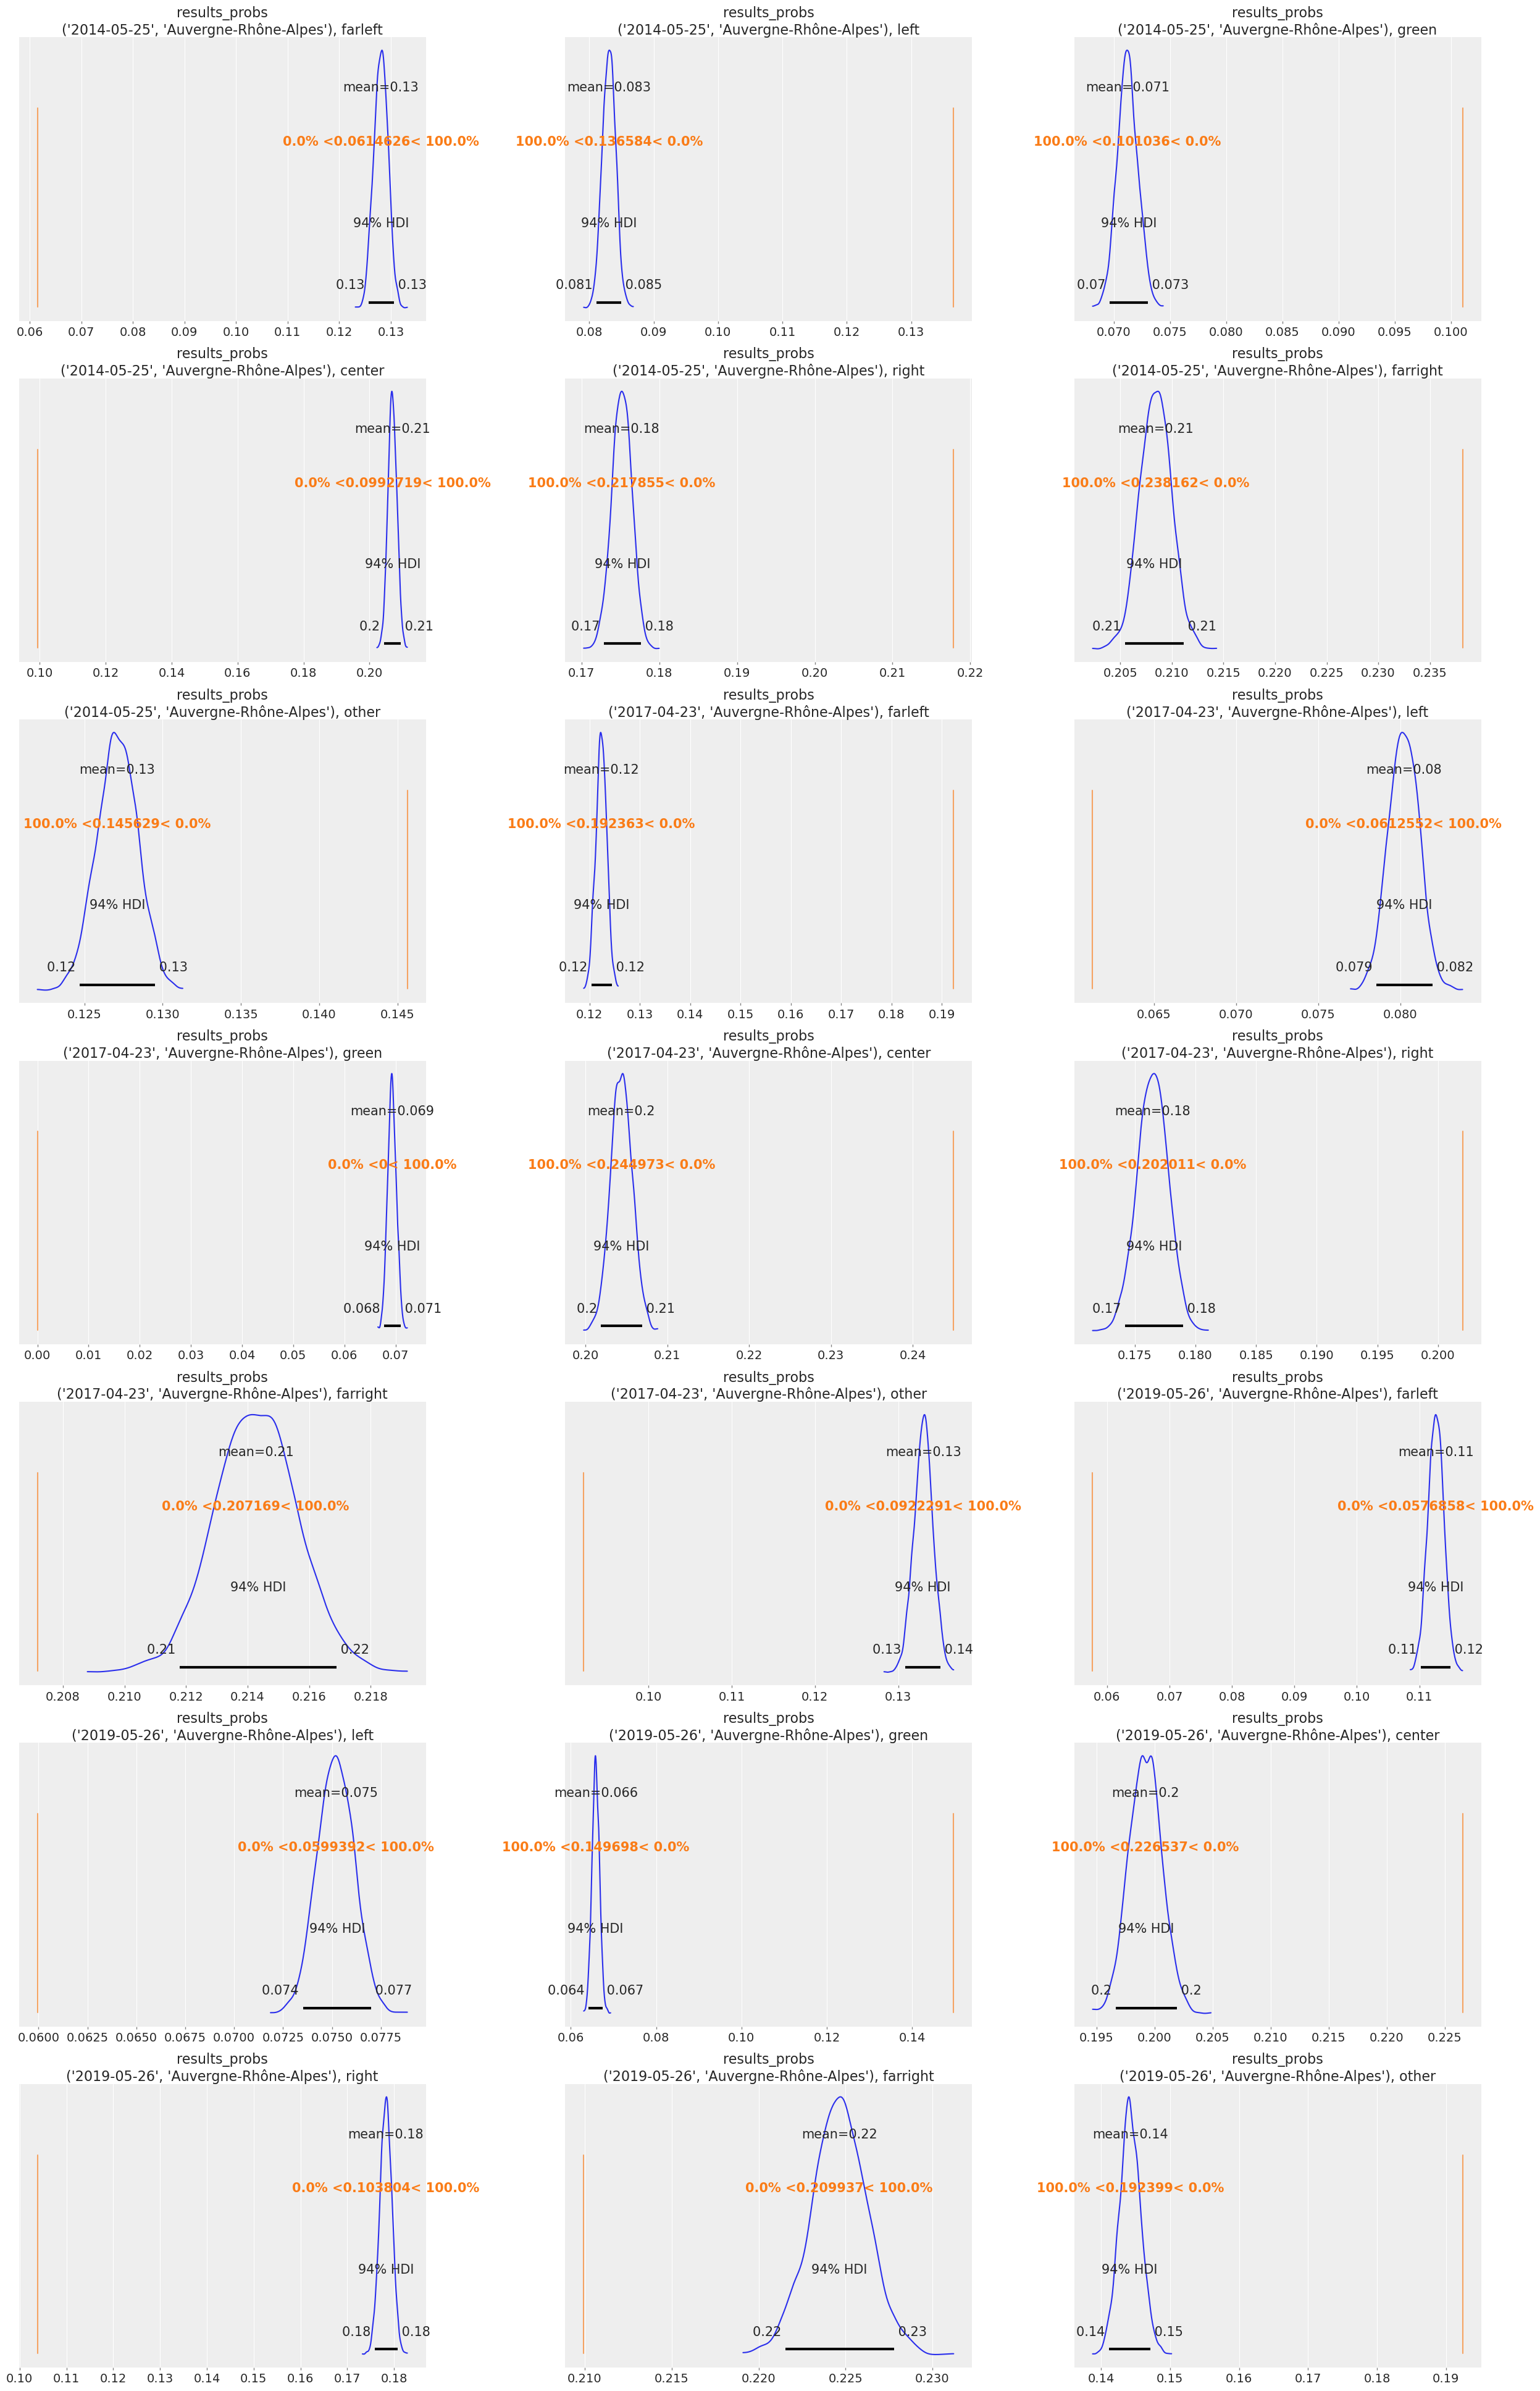

In [44]:
arviz.plot_posterior(
    trace,
    var_names="results_probs",
    coords={
        "observations": [
            ("2014-05-25", "Auvergne-Rhône-Alpes"),
            ("2017-04-23", "Auvergne-Rhône-Alpes"),
            ("2019-05-26", "Auvergne-Rhône-Alpes"),
        ]
    },
    ref_val=ref_vals.loc[(slice(None), "Auvergne-Rhône-Alpes"), :].stack().tolist(),
);

## Remove DOM for whole history

In [77]:
results_by_regions = pd.read_csv(
    "https://raw.githubusercontent.com/pollsposition/data/main/results_by_regions.csv"
)
results_by_regions["region"] = results_by_regions.region.str.replace(
    "La Réunion", "Réunion"
)
subset = (
    results_by_regions[
        (results_by_regions.type.isin(["president", "european"]))
        & (~results_by_regions.region.isin(["Mayotte", 'Guadeloupe', 'Guyane', 'Martinique', 'Réunion']))
    ]
    .reset_index(drop=True)
    .set_index(["election_day", "region"])
    .sort_index()
)
subset

type        N  farleft    left  \
election_day region                                                            
2002-04-21   Auvergne-Rhône-Alpes        president  3321976   323854  472029   
             Bourgogne-Franche-Comté     president  1377707   142423  207869   
             Bretagne                    president  1585745   189416  286515   
             Centre-Val de Loire         president  1221727   125029  184174   
             Corse                       president   109462     6629   16836   
...                                            ...      ...      ...     ...   
2019-05-26   Normandie                    european  1211420    75665   71759   
             Nouvelle-Aquitaine           european  2222990   156342  172774   
             Occitanie                    european  2186389   162093  165841   
             Pays de la Loire             european  1342007    71373   93308   
             Provence-Alpes-Côte d'Azur   european  1710441   100001   76667   

                                          green  center   right  farright  \
election_day region                                                         
2002-04-21   Auvergne-Rhône-Alpes        191041  253051  597258    620297   
             Bourgogne-Franche-Comté      63466   87840  254522    261422   
             Bretagne                    102128  113920  342538    187323   
             Centre-Val de Loire          55098   82415  244240    210385   
             Corse                         3265    3660   30180     17166   
...                                         ...     ...     ...       ...   
2019-05-26   Normandie                   137325  253703   95280    322381   
             Nouvelle-Aquitaine          295549  495592  166505    496762   
             Occitanie                   288703  439620  153909    562721   
             Pays de la Loire            209027  337679  117138    252548   
             Provence-Alpes-Côte d'Azur  200341  348437  150738    521969   

                                          other  
election_day region                              
2002-04-21   Auvergne-Rhône-Alpes        864446  
             Bourgogne-Franche-Comté     360165  
             Bretagne                    363905  
             Centre-Val de Loire         320386  
             Corse                        31726  
...                                         ...  
2019-05-26   Normandie                   255307  
             Nouvelle-Aquitaine          439466  
             Occitanie                   413502  
             Pays de la Loire            260934  
             Provence-Alpes-Côte d'Azur  312288  

[104 rows x 9 columns]

In [79]:
COORDS = {
    "parties": ["farleft", "left", "green", "center", "right", "farright"],
    "parties_complete": [
        "farleft",
        "left",
        "green",
        "center",
        "right",
        "farright",
        "other",
    ],
    "observations": subset.index,
}

In [80]:
# prevents overflow issue
subset[COORDS["parties_complete"]] = subset[COORDS["parties_complete"]] // 100

In [81]:
region_idx, COORDS["regions"] = pd.factorize(
    subset.index.get_level_values("region"), sort=True
)

In [82]:
unemp = pd.read_excel(
    "../../data/predictors/chomage_reg_depart_trim.xls",
    sheet_name="Région",
    header=3,
    nrows=19,
).iloc[2:]

# remove accents and special characters, then remove hyphens
unemp["normalized_region"] = unemp["Libellé"].str.lower().str.replace("-", " ").values

unemp = unemp.drop(["Code", "Libellé"], axis=1).set_index("normalized_region")

In [83]:
# as timestamps variables:
unemp.columns = pd.period_range(
    start=unemp.columns[0].split("_")[1], periods=unemp.shape[1], freq="Q"
)
unemp.columns.name = "quarter"
unemp = pd.DataFrame(unemp.stack().swaplevel(), columns=["unemployment"])

In [85]:
# normalize regions of data before joining
subset["normalized_region"] = (
    subset.reset_index()
    .region.str.lower()
    .str.normalize("NFKD")
    .str.encode("ascii", errors="ignore")
    .str.decode("utf-8")
    .str.replace("-", " ")
    .values
)

subset = subset.reset_index()

# add quarters to results dataframe:
subset["quarter"] = pd.DatetimeIndex(subset["election_day"].values).to_period("Q")
subset = subset.set_index(["quarter", "normalized_region"])

In [86]:
subset = (
    subset.merge(unemp, left_index=True, right_index=True)
    .reset_index(drop=True)
    .set_index(["election_day", "region"])
)

In [90]:
with pm.Model(coords=COORDS) as m_full_no_dom:

    # hierarchical layer cutpoints
    init_mean = np.arange(len(COORDS["parties"])) - 2.5
    mean = pm.Normal(
        "cutpoint_mean",
        mu=init_mean,
        sigma=3.0,
        initval=init_mean,
        transform=pm.distributions.transforms.ordered,
        dims="parties",
    )
    sd = pm.HalfNormal("cutpoint_sd")

    # cutpoints
    init_cut = np.tile(
        np.arange(len(COORDS["parties"])) - 2.5, reps=(len(COORDS["regions"]), 1)
    )
    cutpoints = pm.Normal(
        "cutpoints",
        mu=mean,
        sigma=sd,
        initval=init_cut,
        transform=pm.distributions.transforms.ordered,
        dims=("regions", "parties"),
    )

    # regression
    regression_mean = pm.Normal("regression_mean")
    shrinkage = pm.HalfNormal("regression_shrinkage")
    bU = pm.Normal("unemp_effect", regression_mean, shrinkage, dims="regions")
    U = pm.Data("unemp_data", subset.unemployment.values)
    eta = pm.Deterministic("eta", bU[region_idx] * U, dims="observations")

    pm.OrderedMultinomial(
        "results",
        eta=eta,
        cutpoints=cutpoints[region_idx],
        n=subset[COORDS["parties_complete"]].sum(1).values,
        observed=subset[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    trace_full_no_dom = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={
                "results_probs": ["observations", "parties_complete"]
            },  # "eta": ["observations"]
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoint_mean, cutpoint_sd, cutpoints, regression_mean, regression_shrinkage, unemp_effect]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 99 seconds.


0, dim: observations, 104 =? 104


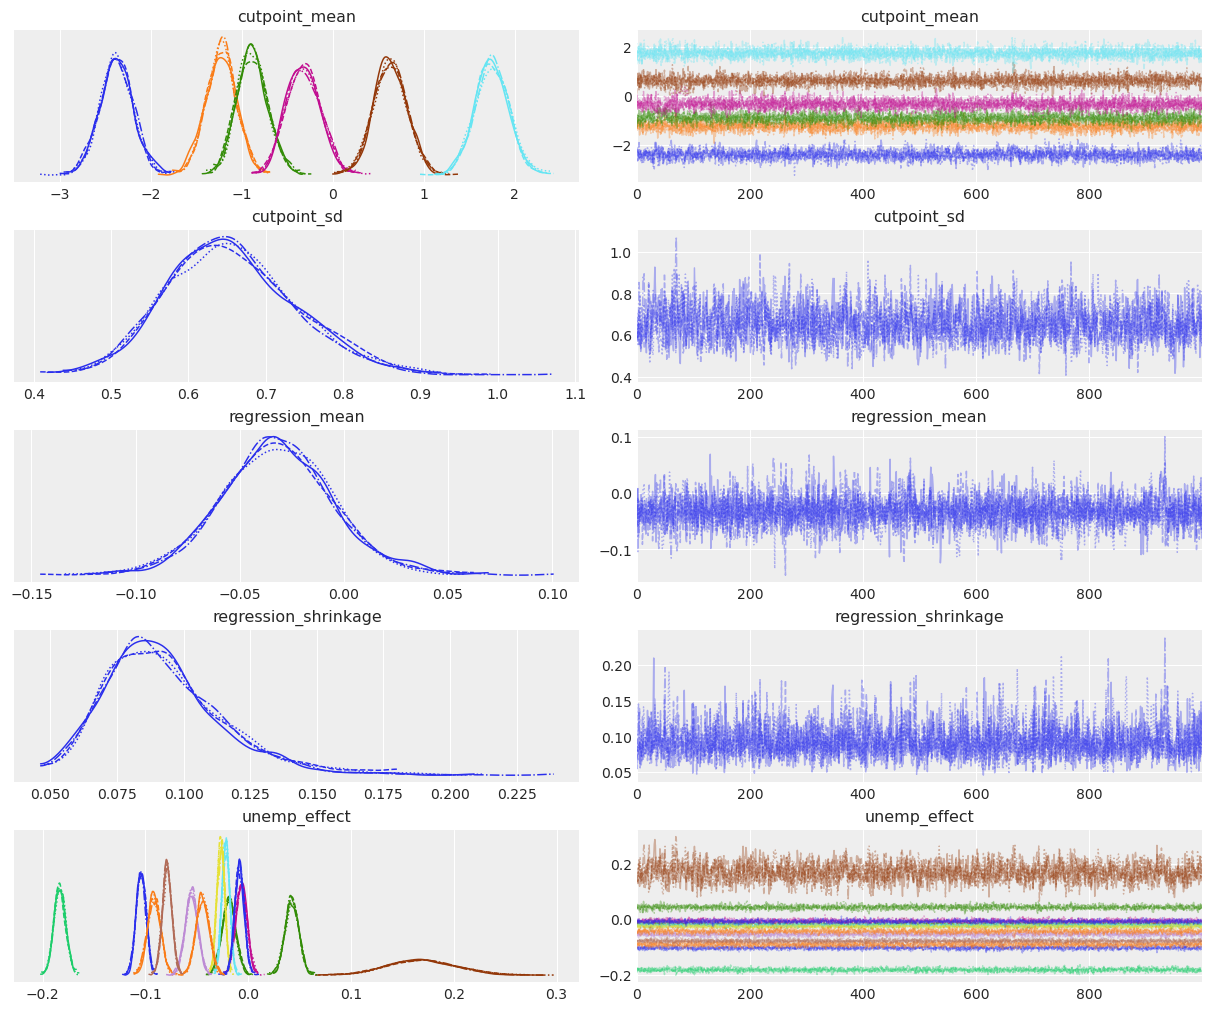

In [92]:
arviz.plot_trace(
    trace_full_no_dom, var_names=["cutpoint_", "regression_", "unemp_effect"], filter_vars="like"
);

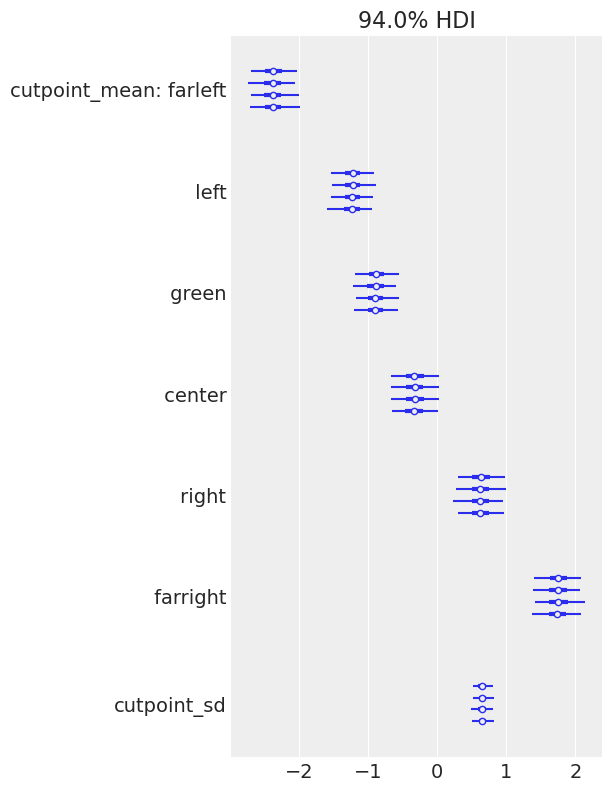

In [93]:
arviz.plot_forest(trace_full_no_dom, var_names=["cutpoint_"], filter_vars="like");

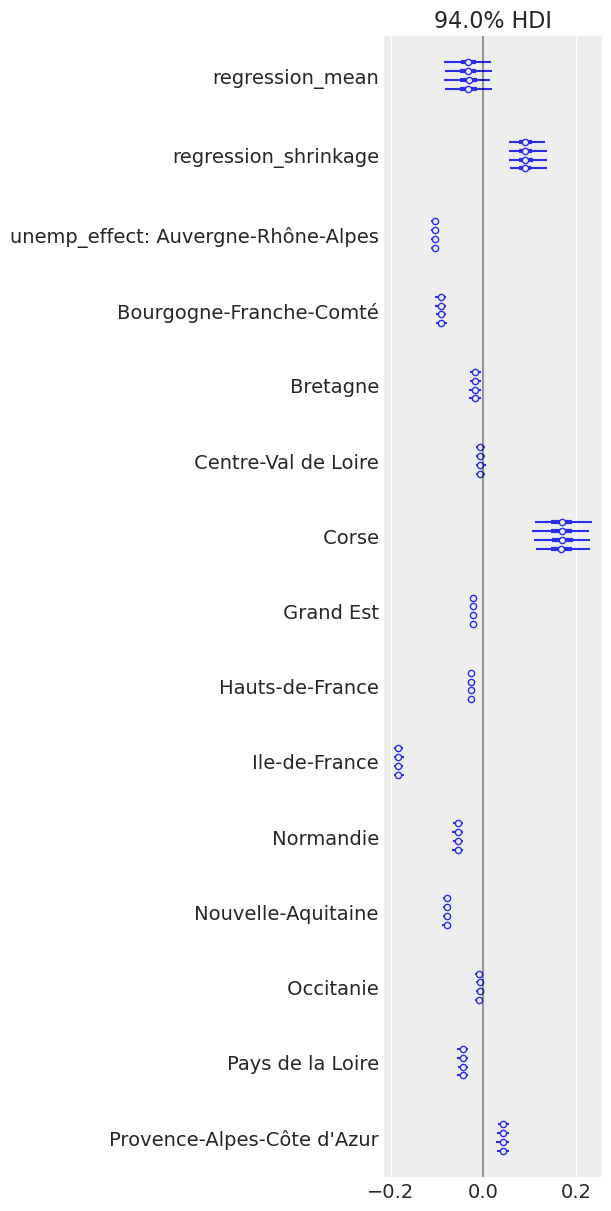

In [94]:
ax = arviz.plot_forest(
    trace_full_no_dom, var_names=["regression_", "unemp_effect"], filter_vars="like"
)
ax[0].axvline(c="k", alpha=0.4);

In [95]:
ref_vals = subset[COORDS["parties_complete"]].div(
    subset[COORDS["parties_complete"]].sum(1).values, axis="rows"
)

In [101]:
ref_vals.loc[(slice(None), "Auvergne-Rhône-Alpes"), :].round(2)

farleft  left  green  center  right  \
election_day region                                                      
2002-04-21   Auvergne-Rhône-Alpes     0.10  0.14   0.06    0.08   0.18   
2004-06-13   Auvergne-Rhône-Alpes     0.08  0.30   0.09    0.13   0.19   
2007-04-22   Auvergne-Rhône-Alpes     0.07  0.24   0.03    0.20   0.32   
2009-06-07   Auvergne-Rhône-Alpes     0.12  0.16   0.18    0.08   0.29   
2012-04-22   Auvergne-Rhône-Alpes     0.12  0.26   0.03    0.10   0.27   
2014-05-25   Auvergne-Rhône-Alpes     0.06  0.14   0.10    0.10   0.22   
2017-04-23   Auvergne-Rhône-Alpes     0.19  0.06   0.00    0.24   0.20   
2019-05-26   Auvergne-Rhône-Alpes     0.06  0.06   0.15    0.23   0.10   

                                   farright  other  
election_day region                                 
2002-04-21   Auvergne-Rhône-Alpes      0.19   0.26  
2004-06-13   Auvergne-Rhône-Alpes      0.10   0.12  
2007-04-22   Auvergne-Rhône-Alpes      0.10   0.04  
2009-06-07   Auvergne-Rhône-Alpes      0.06   0.11  
2012-04-22   Auvergne-Rhône-Alpes      0.18   0.04  
2014-05-25   Auvergne-Rhône-Alpes      0.24   0.15  
2017-04-23   Auvergne-Rhône-Alpes      0.21   0.09  
2019-05-26   Auvergne-Rhône-Alpes      0.21   0.19

In [108]:
trace_full_no_dom.posterior.results_probs.sel(
    observations=[
        ("2002-04-21", "Auvergne-Rhône-Alpes"),
        ("2004-06-13", "Auvergne-Rhône-Alpes"),
        ("2007-04-22", "Auvergne-Rhône-Alpes"),
        ("2009-06-07", "Auvergne-Rhône-Alpes"),
        ("2012-04-22", "Auvergne-Rhône-Alpes"),
        ("2014-05-25", "Auvergne-Rhône-Alpes"),
        ("2017-04-23", "Auvergne-Rhône-Alpes"),
        ("2019-05-26", "Auvergne-Rhône-Alpes"),
    ]
).mean(("chain", "draw")).to_dataframe().unstack().mean().round(2)

               parties_complete
results_probs  farleft             0.10
               left                0.17
               green               0.06
               center              0.15
               right               0.23
               farright            0.16
               other               0.11
dtype: float64

In [110]:
trace.posterior.results_probs.sel(
    observations=[
        ("2014-05-25", "Auvergne-Rhône-Alpes"),
        ("2017-04-23", "Auvergne-Rhône-Alpes"),
        ("2019-05-26", "Auvergne-Rhône-Alpes"),
    ]
).mean(("chain", "draw")).to_dataframe().unstack().mean().round(2)

               parties_complete
results_probs  farleft             0.12
               left                0.08
               green               0.07
               center              0.20
               right               0.18
               farright            0.22
               other               0.13
dtype: float64

/Users/alex_andorra/opt/anaconda3/envs/pymc3-dev-py39/lib/python3.9/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (56) in plot_posterior, generating only 40 plots
  warnings.warn(


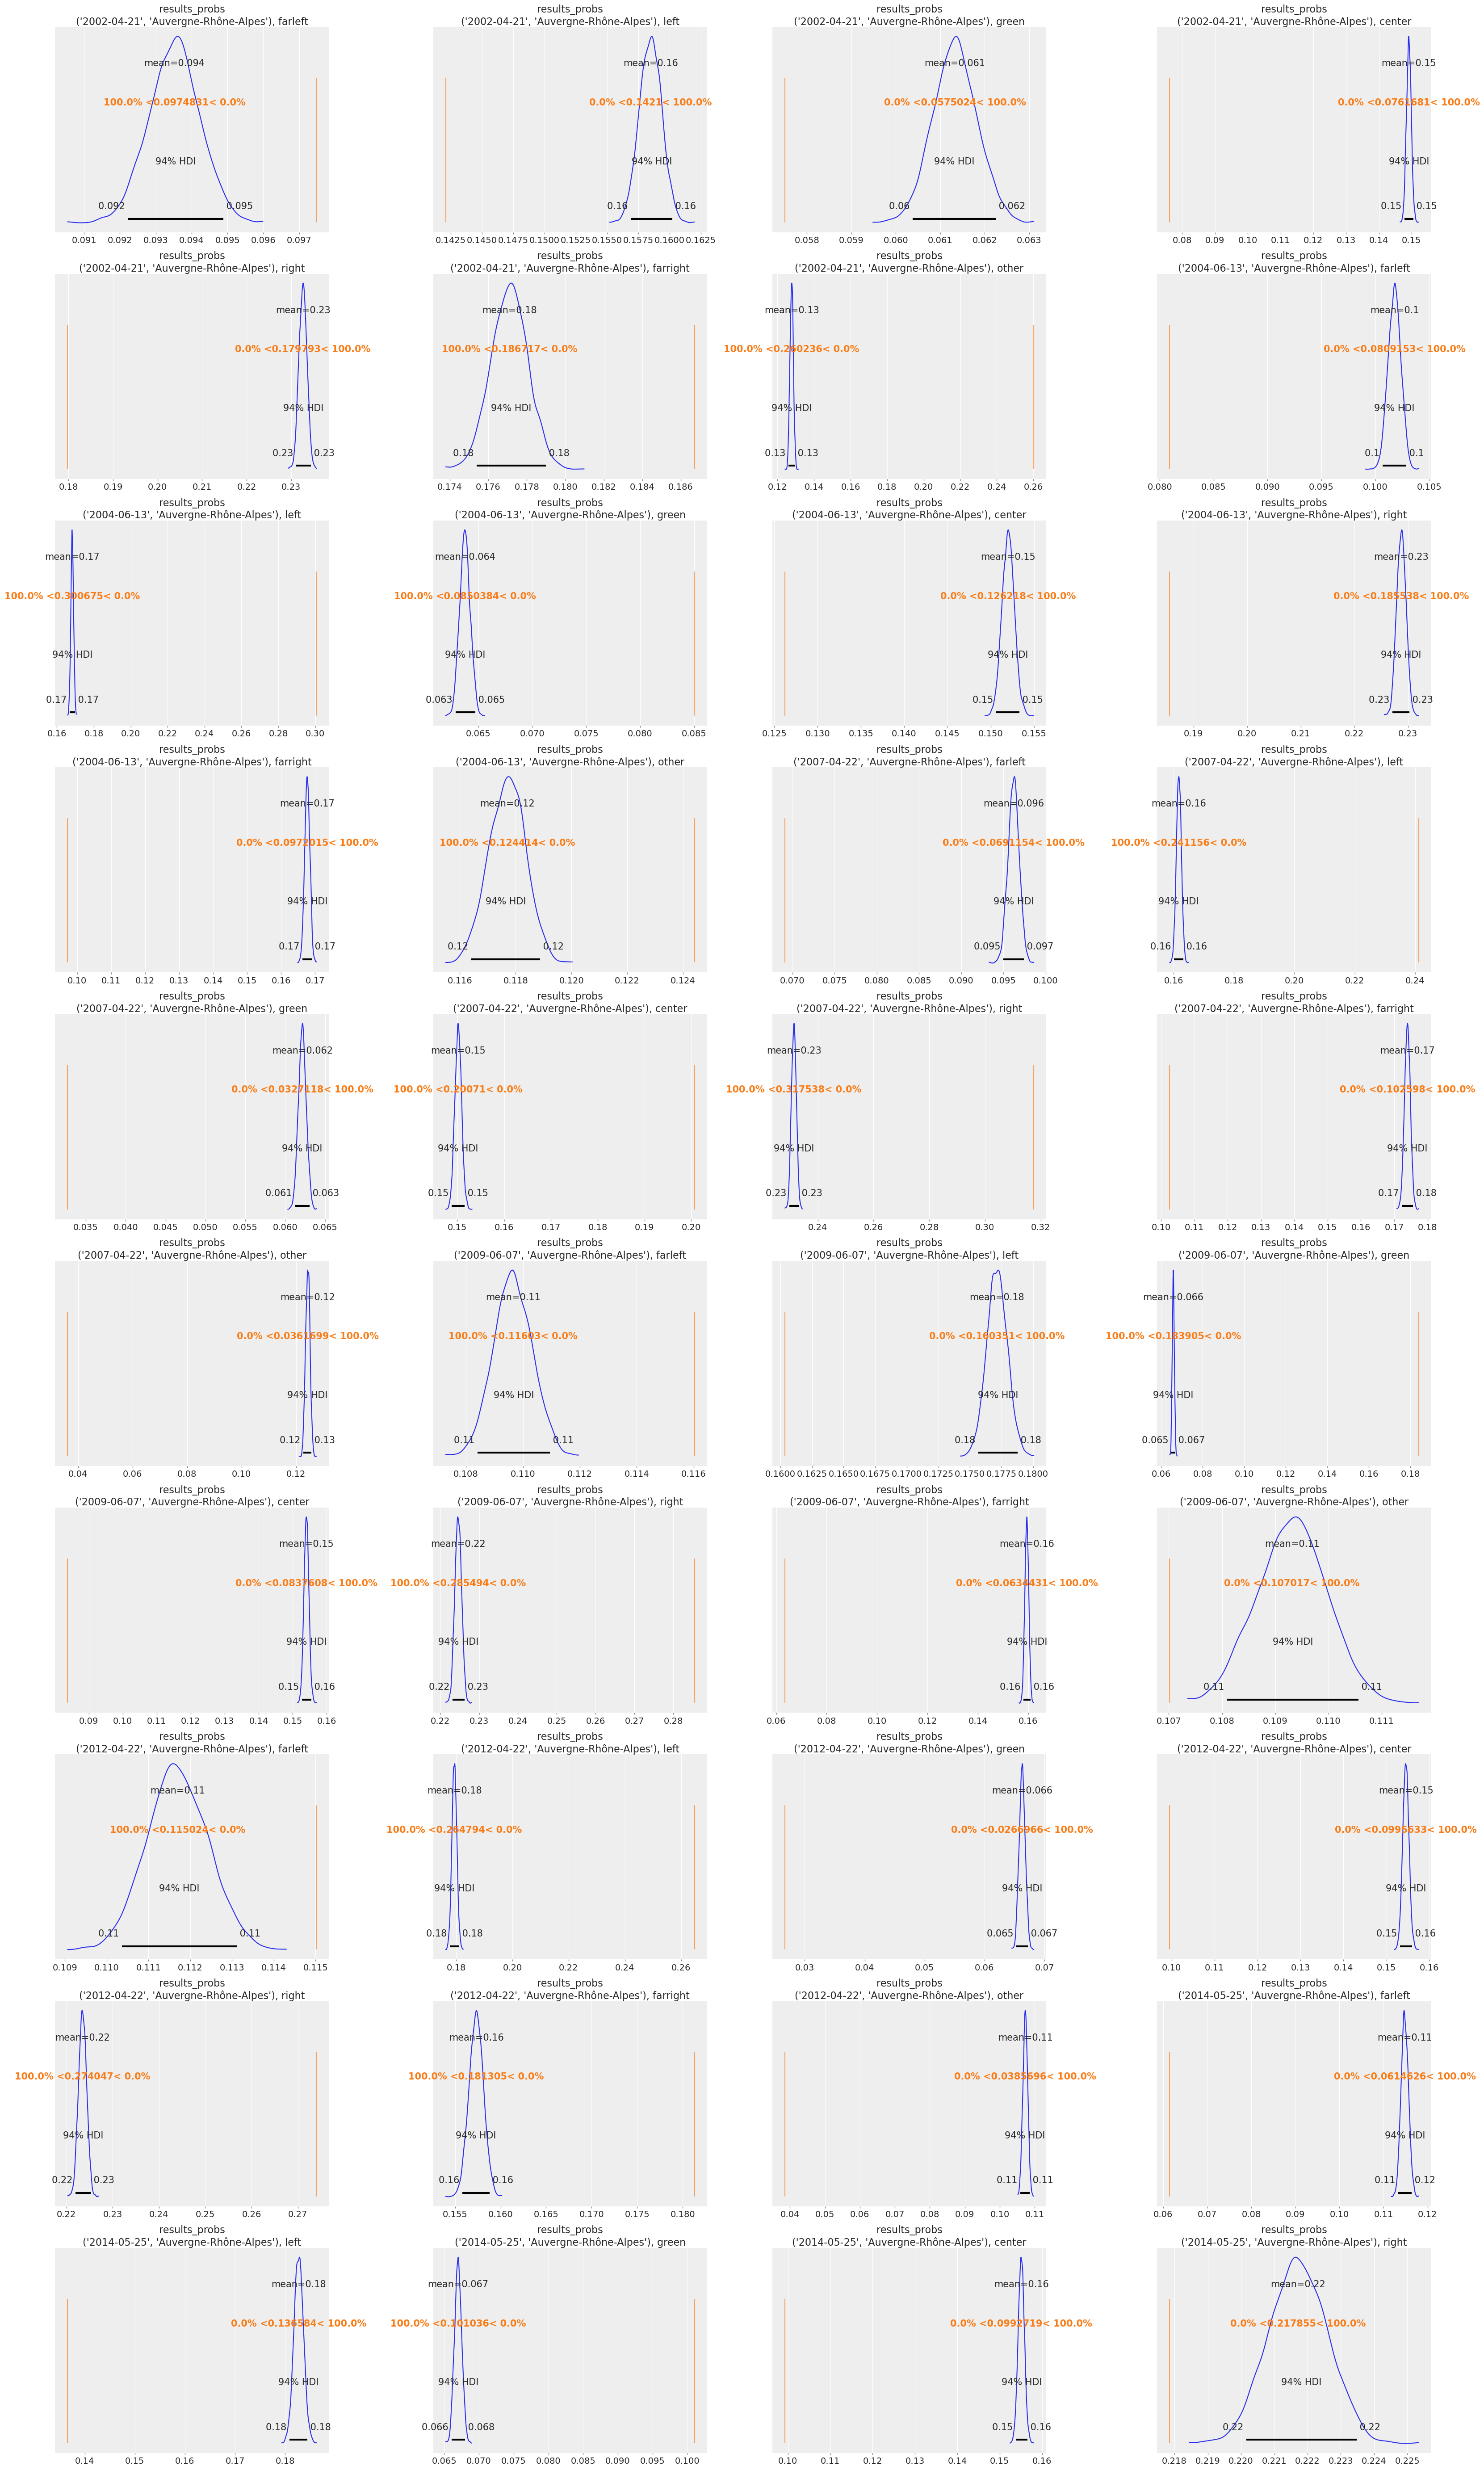

In [100]:
arviz.plot_posterior(
    trace_full_no_dom,
    var_names="results_probs",
    coords={
        "observations": [
            ("2002-04-21", "Auvergne-Rhône-Alpes"),
            ("2004-06-13", "Auvergne-Rhône-Alpes"),
            ("2007-04-22", "Auvergne-Rhône-Alpes"),
            ("2009-06-07", "Auvergne-Rhône-Alpes"),
            ("2012-04-22", "Auvergne-Rhône-Alpes"),
            ("2014-05-25", "Auvergne-Rhône-Alpes"),
            ("2017-04-23", "Auvergne-Rhône-Alpes"),
            ("2019-05-26", "Auvergne-Rhône-Alpes"),
        ]
    },
    ref_val=ref_vals.loc[(slice(None), "Auvergne-Rhône-Alpes"), :].stack().tolist(),
);

## Infer DOM's unemployment